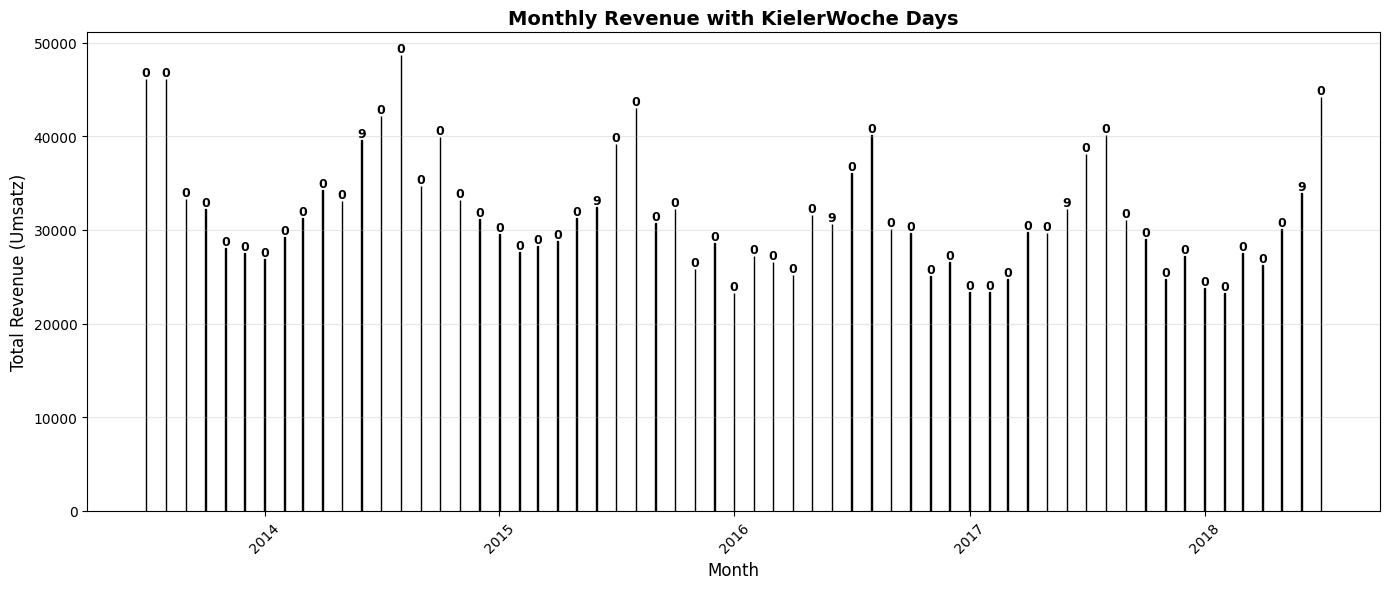

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  KielerWoche YearMonth  
0        20.0            0   2013-07  
1         NaN            0   2013-07  
2        61.0            0   2013-07  
3        20.0            0   2013-07  
4         NaN            0   2013-07  


In [419]:
import pandas as pd
import matplotlib.pyplot as plt

# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"

# load sales and aggregate to daily total
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])

# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")

# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()

# create bar chart
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(monthly["YearMonth"], monthly["Umsatz"], color="steelblue", edgecolor="black")

# add KielerWoche count labels above bars
for i, (bar, kiwo_count) in enumerate(zip(bars, monthly["KielerWoche"])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f"{int(kiwo_count)}",
            ha="center", va="bottom", fontsize=9, fontweight="bold")

# formatting
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Total Revenue (Umsatz)", fontsize=12)
ax.set_title("Monthly Revenue with KielerWoche Days", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

In [420]:
# translations 
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielWeek'}, inplace=True)
print(merged)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
1814 2018-07-27  1572.847053         0.0      27.5875       16.0          5.0   
1815 2018-07-28  1646.938417         3.0      28.7500       11.0         95.0   
1816 2018-07-29  1750.221545         0.0      24.5500        6.0          NaN   
1817 2018-07-30  1510.458573         6.0      27.7875       10.0         21.0   
1818 2018-07-31  1313.474071         5.0      31.2875       11.0          NaN   

      KielWeek YearMonth  


In [421]:
# descriptive statistics
import numpy as np

# basic shape and info
print('Shape:', merged.shape)

# basic descriptive statistics for key variables
stats = merged[['Revenue', 'CloudCover','Temperature','WindSpeed']].describe()
print('Descriptive statistics for key variables:')
print(stats)

Shape: (1819, 8)
Descriptive statistics for key variables:
           Revenue   CloudCover  Temperature    WindSpeed
count  1819.000000  1807.000000   1816.00000  1816.000000
mean   1060.910160     4.688434     12.20778    10.996696
std     290.267632     2.650726      7.26073     4.128913
min     525.973832     0.000000     -8.47500     3.000000
25%     850.806263     3.000000      6.37500     8.000000
50%    1001.424738     6.000000     12.04375    10.000000
75%    1226.344892     7.000000     18.12500    13.000000
max    3156.413344     8.000000     31.43750    35.000000


In [422]:
# cleaning the dataset 

# analyse the 'Not a Number' (NaN) values in each column
# the intention is to remove from the dataset rows containing NaN values
nan_per_column = merged.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

# the intention is to remove from the dataset rows containing NaN values
merged_cleaned = merged.dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
print(merged_cleaned)
print('Shape after cleaning:', merged_cleaned.shape)

NaN values in each column:
Date             0
Revenue          0
CloudCover      12
Temperature      3
WindSpeed        3
WeatherCode    459
KielWeek         0
YearMonth        0
dtype: int64
           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
1814 2018-07-27  1572.847053         0.0      27.5875       16.0          5.0   
1815 2018-07-28  1646.938417         3.0      28.7500       11.0         95.0   
1816 2018-07-29  1750.221545         0.0      24.5500        6.0          NaN  

In [423]:
# searching duplicates

def count_duplicates(df: pd.DataFrame):

    duplicated_rows = df[df.duplicated(keep='first')]
    return len(duplicated_rows), duplicated_rows

n_duplicates, rows = count_duplicates(merged_cleaned)
print("Number of duplicates:", n_duplicates)
print(rows)

Number of duplicates: 0
Empty DataFrame
Columns: [Date, Revenue, CloudCover, Temperature, WindSpeed, WeatherCode, KielWeek, YearMonth]
Index: []


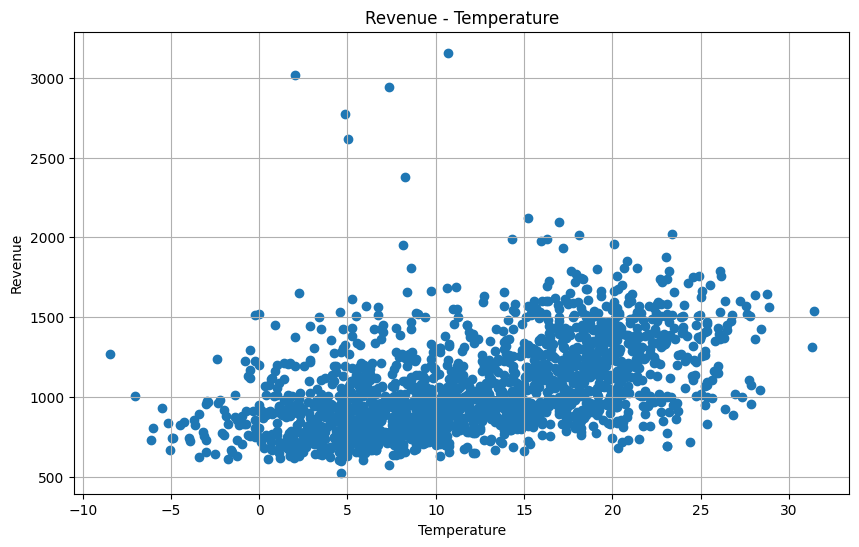

In [424]:
# plot Revenue - Temperature relationship

def plot_revenue_vs_temperature(df, x, y):

    # ensure columns exist
    if x not in df.columns or y not in df.columns:
        raise ValueError(f"Columns '{x}' and/or '{y}' not found in DataFrame")

    plt.figure(figsize=(10, 6))
    plt.scatter(df[x], df[y]) # scatter allows for visualizing relation clearly
    plt.xlabel("Temperature")
    plt.ylabel("Revenue")
    plt.title("Revenue - Temperature")
    plt.grid(True)
    plt.show()
    
plot_revenue_vs_temperature(merged_cleaned, 'Temperature', 'Revenue')

In [425]:
# check data types
merged_cleaned.dtypes

Date           datetime64[ns]
Revenue               float64
CloudCover            float64
Temperature           float64
WindSpeed             float64
WeatherCode           float64
KielWeek                int64
YearMonth           period[M]
dtype: object

In [426]:
# set Date as index
merged_cleaned.set_index('Date', inplace=True)
merged_cleaned

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielWeek,YearMonth
Date,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,0,2013-07
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,0,2013-07
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,0,2013-07
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,0,2013-07
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,0,2013-07
...,...,...,...,...,...,...,...
2018-07-27,1572.847053,0.0,27.5875,16.0,5.0,0,2018-07
2018-07-28,1646.938417,3.0,28.7500,11.0,95.0,0,2018-07
2018-07-29,1750.221545,0.0,24.5500,6.0,NaN,0,2018-07


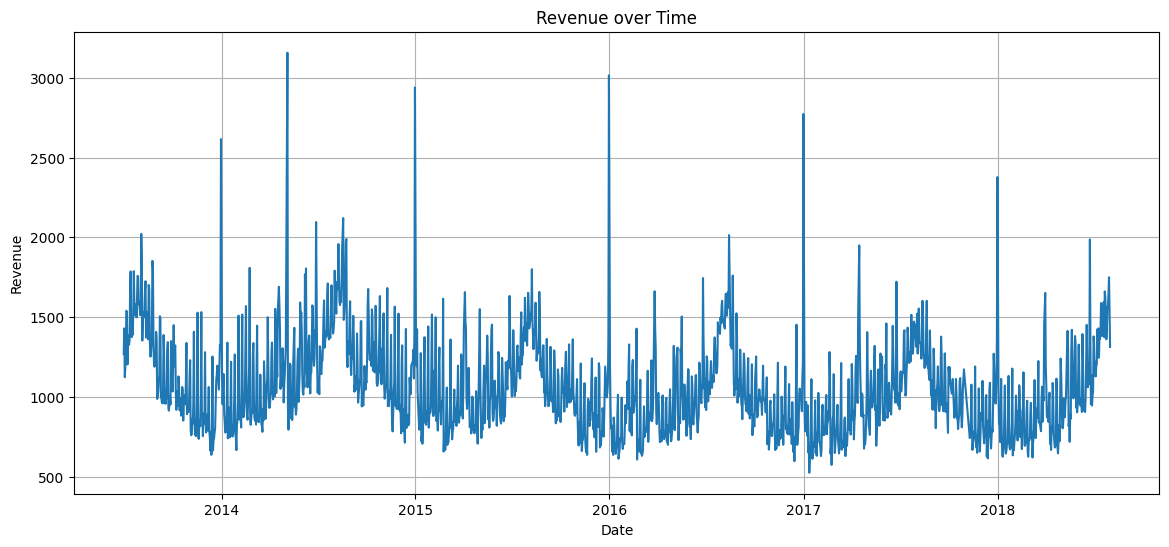

In [427]:
# visualize Revenue over time
plt.figure(figsize=(14, 6))
plt.plot(merged_cleaned.index, merged_cleaned['Revenue'], linestyle='-')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue over Time')
plt.grid(True)
plt.show()  

/tmp/ipykernel_14718/1770316980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned['Revenue_14days'] = merged_cleaned['Revenue'].rolling(window=14, center=True).mean()


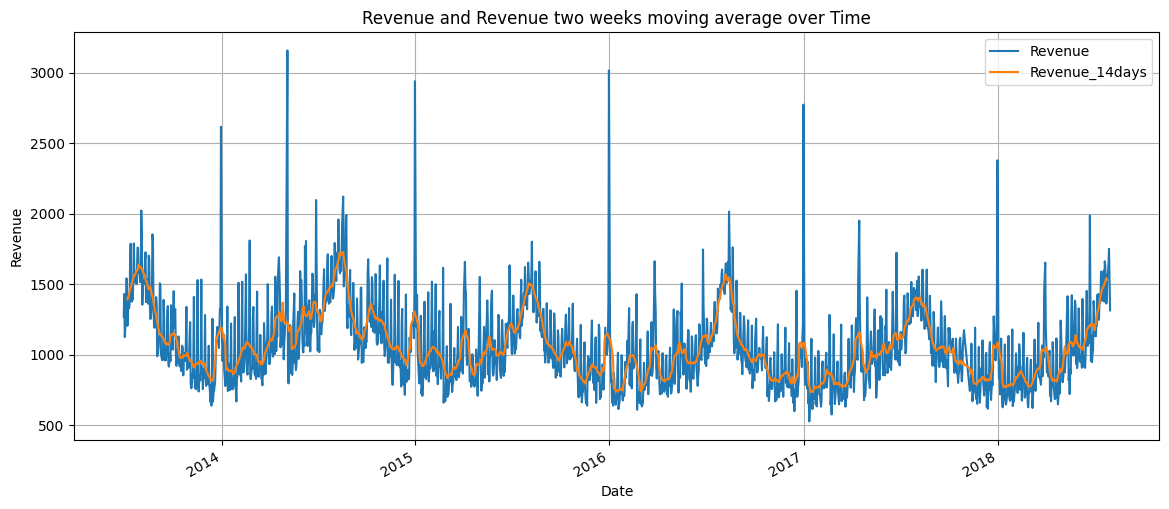

In [428]:
# remove noise in the Revenue data using rolling mean
merged_cleaned['Revenue_14days'] = merged_cleaned['Revenue'].rolling(window=14, center=True).mean()   
merged_cleaned['Revenue_14days'] # Revenue two weeks moving average

merged_cleaned[['Revenue', 'Revenue_14days']].plot(figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue and Revenue two weeks moving average over Time')  
plt.grid(True)
plt.show()

/tmp/ipykernel_14718/2188353960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned['Revenue_yearly'] = merged_cleaned['Revenue'].rolling(window=365, center=True).mean()


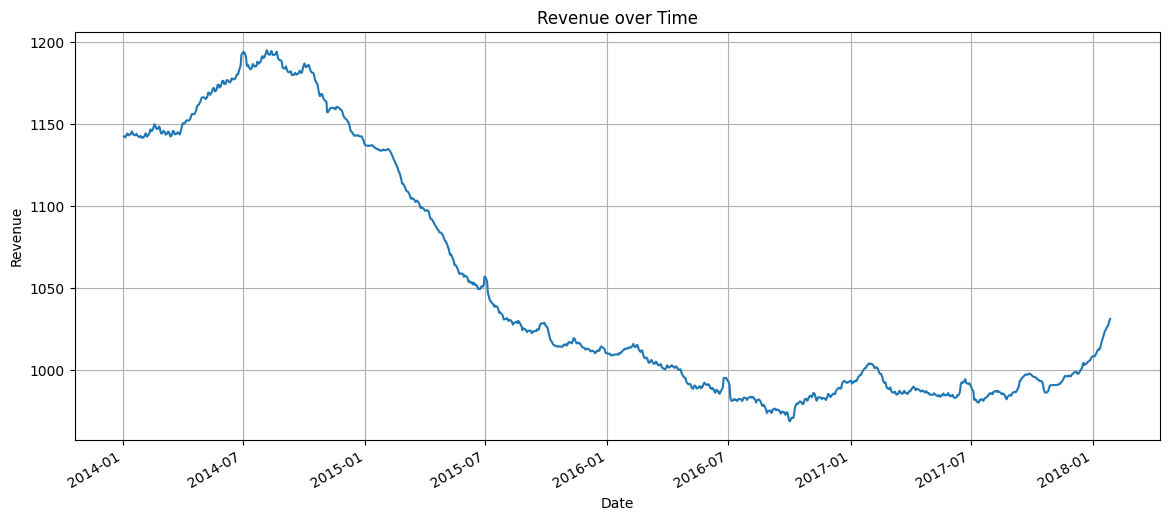

In [429]:
# Revenue 12 months moving average
merged_cleaned['Revenue_yearly'] = merged_cleaned['Revenue'].rolling(window=365, center=True).mean()   
merged_cleaned['Revenue_yearly'] 

merged_cleaned['Revenue_yearly'].plot(figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue over Time')  
plt.grid(True)
plt.show()

/tmp/ipykernel_14718/78569252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned['Revenue_pct_change'] = merged_cleaned['Revenue'].pct_change() * 100


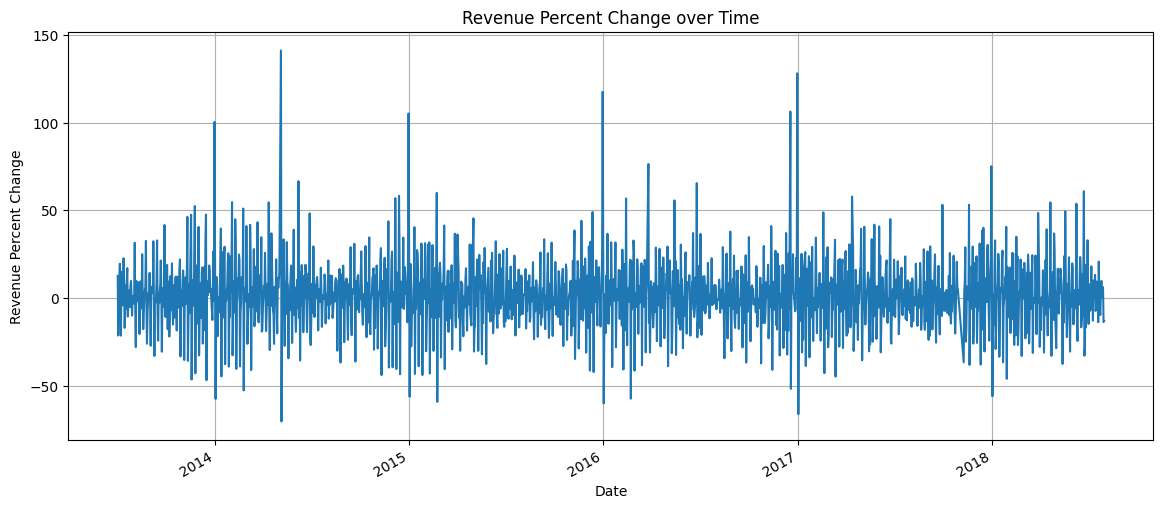

In [430]:
# investigate percent change in Revenue
merged_cleaned['Revenue_pct_change'] = merged_cleaned['Revenue'].pct_change() * 100
merged_cleaned['Revenue_pct_change'].head()

merged_cleaned['Revenue_pct_change'].plot(figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Revenue Percent Change')        
plt.title('Revenue Percent Change over Time')
plt.grid(True)
plt.show()

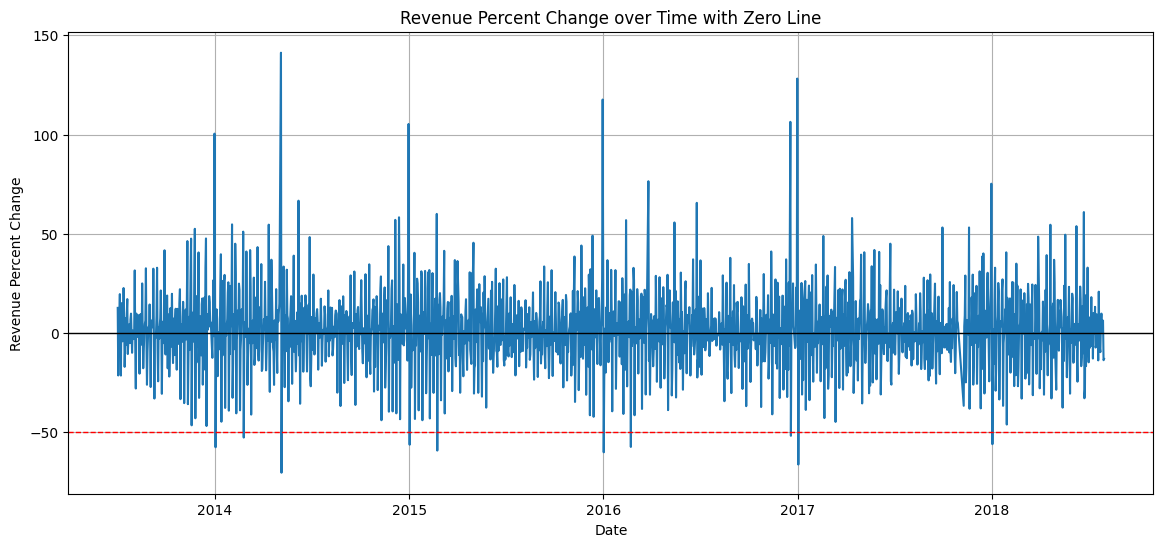

In [431]:
# add a horizontal line at y=0
plt.figure(figsize=(14, 6))
plt.plot(merged_cleaned.index, merged_cleaned['Revenue_pct_change'], linestyle='-')
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axhline(-50, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Revenue Percent Change')        
plt.title('Revenue Percent Change over Time with Zero Line')
plt.grid(True)
plt.show()

In [ ]:
# the major dips in revenue occurred around the following dates:
dips = merged_cleaned[merged_cleaned['Revenue_pct_change'] <= -50]
dips.count()
print(dips.index)

DatetimeIndex(['2014-01-02', '2014-02-24', '2014-05-06', '2015-01-02',
               '2015-02-23', '2016-01-02', '2016-02-22', '2016-12-19',
               '2017-01-02', '2018-01-02'],
              dtype='datetime64[ns]', name='Date', freq=None)
